# Gaussian Quadrature #

## Introduction ##

Gaussian quadrature is a method of numerical integration that aims to be more precise than the rectangle, trapezoidal, or the Simpson method of integration. Similar to Simpson's Rule, the method of Gaussian Quadrature for integrating a function is a sum of weighted function values at specific points, called nodes, that lie on the x-axis. Mathematically, if we want to integrate a function on the interval $[-1,1]$, it is given by:
$$ \int_{-1}^{1}f(x)\thinspace dx = \sum_{k=1}^n\omega_kf(x_k).$$
The key difference between Simpson's Rule and Gaussian Quadrature is that, in Simpson's rule, the nodes have to be spaced evenly, while in Gaussian Quadrature they do not. In fact, Gaussian Quadrature is more accurate if we do not use evenly spaced nodes.

In Gaussian Quadrature, there are also no restrictions placed on the nodes or the weights of those nodes. As long as the sum gives an exact answer for high-degree polynomials, it can be assumed that it will work for functions that can be approximated as polynomials.

Also, technically the method of Gaussian Quadrature only works on the interval $[-1,1]$. However, if we wanted to integrate on the general inteval $[\alpha, \beta]$, we can make an appropriate change of variables to shift from $[\alpha, \beta]$ to $[-1,1]$.

## Goal ##

Trigonometric functions on certain intervals can be approximated as a polynomial of high degree. Therefore, a good test would be to apply the method of Gaussian Quadrature to integrate a function like $f(x) = \tan(x^2)$ over the interval $[0,1]$. In code the function is

In [2]:
import numpy as np

def f(x):
    return np.tan(x**2)

and the graph looks like

In [3]:
import matplotlib.pyplot as plt

x = np.linspace(0,1,1000)
y = f(x)

plt.plot(x,y)
plt.title("Graph of Region to be Integrated")
plt.ylabel("tan($x^2$)")
plt.xlabel("x")
plt.show()

<Figure size 640x480 with 1 Axes>

## Method ##

### Preliminaries ###

Let us first form the theory behind Gaussian Quadrature before we actually do any integration. 

We want to integrate some function $f(x)$ on the interval $[-1,1]$.The theory tells us that we can get a numerical value for the definite integral by considering a weighted sum of the function evaluated at certain nodes. That is
$$ \int_{-1}^{1}f(x)\thinspace dx = \sum_{k=1}^n\omega_kf(x_k).$$

The only caveat for the choice of node and corresponding weight is that it must be accurate for as high degree a polynomial as possible. 

Since we are considering a sum over $n$ nodes, there are $2n$ unknowns to solve for. Hence, we will choose our Gaussian Quadrature to be accurate for a polynomial of degree up to $2n-1$.

So we must have that
\begin{equation}
 \int_{-1}^{1}x^m\thinspace dx = \sum_{k=1}^n\omega_kf(x_k) = \omega_1x_1^m + \omega_2x_2^m + \omega_3x_3^m + ... + \omega_nx_n^m \tag{1}
 \end{equation}
for $m=0,1,2,3,4,...,2n-1$.

If $m$ is odd, then the integral is 0 since we are integrating over a symmetric integral. If $m$ is even, then 
$$ \int_{-1}^{1}x^m\thinspace dx = 2\int_0^1x^m\thinspace dx = \frac{2x^{m+1}}{m+1}\bigg|_0^1 = \frac{2}{m+1}.$$
More succintly,
$$ \int_{-1}^{1}x^m\thinspace dx = 
\begin{array}{cc}
  \bigg\{ & 
    \begin{array}{cc}
      0 & \text{m is odd} \\
      \frac{2}{m+1} & \text{m is even} \\
    \end{array}
\end{array}.
$$

Equation $(1)$ is actually a system of $2n$ equations with $2n$ unknowns so, theoretically, we could potentially solve for $\omega_i$ and $x_i$. 

However, we can make the process simpler.

### Simplification ###


As it turns out, on the interval $[-1,1]$, it is very useful to utilize the Legendre polynomials to assist in searching for the weights.

An efficient way to find the nodes is to just use the roots of the n$^\text{th}$-degree Legendre polynomial, $P_n(x)$. In fact, the roots of the Legendre polynomial provide the exactness of $2n-1$, the maximum degree that we originally wanted.

Knowing that we can use the roots of Legendre polynomials for our nodes, it turns out that we can generate the weights by using the formula
$$\omega_i = \frac{2}{\left(1-x_i^2\right)\left[P'_n(x_i)\right]^2}.$$

## Implementation ##

We will now implement the above mathematical theory to create a function that can evaluate an integral over the integral $[-1,1]$ using Gaussian Quadrature. For the implementation we will integrate the basic function $g(x) = cos(x)$.

In [4]:
def g(x):
    return np.cos(x)

The Legendre polynomials can be called using SciPy. For example, the fifth order Legendre polynomial is

In [5]:
import scipy.special as sp

print(sp.legendre(5))

       5        3             2
7.875 x - 8.75 x - 4.372e-16 x + 1.875 x


Or knowing that the $0^{th}$ order Legendre polynomial is 1. We may use the recursive formula for Legendre Polynomials
$$(n+1)P_{n+1} = (2n+1)xP_n - nP_{n-1}$$
with $P_0 = 1$ and $P_1 = x$. 

There is a similar recursion relation used to solve for the derivative of a Legendre Polynomial
$$(x^2-1)P'_n = nxP_n - nP_{n-1}.$$

We will also use Newton's method to find the roots of the Legendre Polynomials.
$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$

In [6]:
import scipy
def GaussQuad(f,n):
    
    #Initial Approximations for Roots of Legendre Polynomial
    x = np.zeros(n,float)
    for i in range(n):
        x[i] = (1-(1/(8*n**2))+(1/(8*n**3)))*(np.cos((np.pi*(4*i-1))/(4*n+2)))
    
    #Initial Approximation from Lecture 5 Code
    #c = np.linspace(3,4*n-1,n)/(4*n+2)
    #x = np.cos(np.pi*a+1/(8*n*n*np.tan(a)))
        
    # Find roots using Newton's method
    # From Lecture 5
    epsilon = 1e-15
    delta = 1.0
    while delta>epsilon:
        p0 = np.ones(n,float)
        p1 = np.copy(x)
        for k in range(1,n):
            '''
            p2 = ((2*k+1)*x*p1-k*p0)/(k+1)
            p0 = p1
            p1 = p2
            '''
            p0,p1 = p1,((2*k+1)*x*p1-k*p0)/(k+1)
            
        dp = (n+1)*(p0-x*p1)/(1-x*x)
        dx = p1/dp
        x -= dx
        delta = max(abs(dx))
    w = 2/((1-x**2)*dp*dp)
    return np.dot(f(x),w)
    
    

In [7]:
#x,w = GaussQuad(g,10000)
print(GaussQuad(g,10000))

1.682605431703398


## General Interval ##

If we want to integrate a function on the more general interval $[\alpha, \beta]$. Then we have to make a variable transformation:
$$\int_\alpha^\beta f(x)\thinspace dx = 
\frac{\beta-\alpha}{2}\sum_{k=1}^n \omega_k f\left(\frac{\beta-\alpha}{2}x_k + \frac{\beta+\alpha}{2}\right)$$
where $\omega_i$ and $x_i$ are the weights and nodes defined above.

In [8]:
def g(x):
    return np.cos(x)

def GenGaussQuad(f,n,a,b):
    #Initial Approximations for Roots of Legendre Polynomial
    x = np.zeros(n,float)
    for i in range(n):
        x[i] = (1-(1/(8*n**2))+(1/(8*n**3)))*(np.cos((np.pi*(4*i-1))/(4*n+2)))
    
    #Initial Approximation from Lecture 5 Code
    #c = np.linspace(3,4*n-1,n)/(4*n+2)
    #x = np.cos(np.pi*a+1/(8*n*n*np.tan(a)))
        
    # Find roots using Newton's method
    # From Lecture 5
    epsilon = 1e-15
    delta = 1.0
    while delta>epsilon:
        p0 = np.ones(n,float)
        p1 = np.copy(x)
        for k in range(1,n):
            '''
            p2 = ((2*k+1)*x*p1-k*p0)/(k+1)
            p0 = p1
            p1 = p2
            '''
            p0,p1 = p1,((2*k+1)*x*p1-k*p0)/(k+1)
            
        dp = (n+1)*(p0-x*p1)/(1-x*x)
        dx = p1/dp
        x -= dx
        delta = max(abs(dx))
    w = 2/((1-x**2)*dp*dp)
    h = 1.0*b - 1.0*a
    z = 1.0*b + 1.0*a
    b = (0.5*h*x) + (z*0.5)
    num = np.dot(f(b),w)
    answer = h*num*0.5
    return answer

In [21]:
print(GenGaussQuad(g,10000, 0,1))

0.8413026988002812


Now we can integrate our goal function $f(x) = tan(x^2)$ on $[0,1]$.

In [10]:
print(GenGaussQuad(f,10000,0,1))

0.39833483142750437


## Comparison with Simpson's Rule ##

In [11]:
def Simpson(f,start, end, parts):
    """
    Simpson sum rule

    """
    #define the X,Y points
    deltax = (end - start) / parts
    resultsx = np.linspace(start, end, parts+1)
    #resultsx = np.append(resultsx, end+deltax)
    resultsy = f(resultsx)

    # To calculate the area
    area = np.empty([parts+1], float)
    for i in range(parts+1):
        if i == 0 or i == parts:
            coef = 1/3
        elif i%2 == 1:
            coef = 4/3
        else: 
            coef = 2/3
        area[i] = coef*resultsy[i]*deltax
        #print(resultsx[i], resultsy[i], coef)


    return sum(area)

In [12]:
print(Simpson(f,0,1,10000))

0.39841444459716596


Wolfram Alpha gives the answer to the integral as the one we got using Simpson's Rule

In [13]:
import time

timesimps = []
timegq = []

for k in range(10):
    t1 = time.time()
    Simpson(f,0,1,10000)
    t2 = time.time()
    timesimps.append(t2-t1)
    

    

In [14]:
for k in range(10):
    t1 = time.time()
    GenGaussQuad(f,10000,0,1)
    t2 = time.time()
    timegq.append(t2-t1)

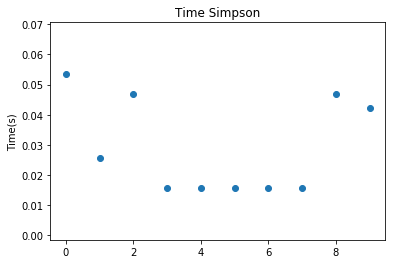

In [15]:
plt.scatter(range(10), timesimps)
plt.ylabel("Time(s)")
plt.title("Time Simpson")
plt.show()

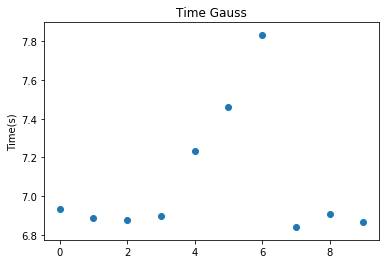

In [16]:
plt.scatter(range(10), timegq)
plt.ylabel("Time(s)")
plt.title("Time Gauss")
plt.show()

## Rate of Convergence Graph ##

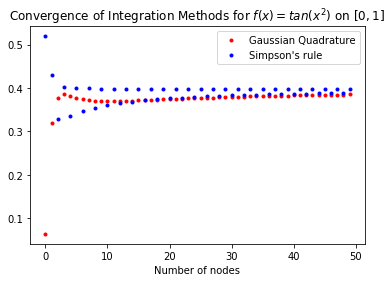

In [34]:
x = range(1,51)
yg =[]
for i in x:
    yg.append(GenGaussQuad(f,i,0,1))
    
ys = []
for i in x:
    ys.append(Simpson(f,0,1,i))
    
plt.plot(yg,'r.', label = 'Gaussian Quadrature')
plt.plot(ys,'b.', label = "Simpson's rule")
plt.xlabel('Number of nodes')
plt.title('Convergence of Integration Methods for $f(x)=tan(x^2)$ on $[0,1]$')
plt.legend()
plt.show()

As we can see, Gaussian Quadrature converges very quickly using only a small number of nodes.

## References ##

Atkinson, K. E. (n.d.). Numerical Integration: Another Approach. Retrieved November 29, 2018, from http://homepage.math.uiowa.edu/~atkinson/ftp/ENA_Materials/Overheads/sec_5-3.pdf

Lambers, J. (2009). Gaussian Quadrature. Retrieved December 1, 2018, from http://www.math.usm.edu/lambers/mat460/fall09/lecture31.pdf

Recursive Formula for Legendre Polynomials. (2011, February 6). Retrieved December 1, 2018, from http://cacs.usc.edu/education/phys516/RecursiveLegendre.pdf

Roots of Legendre Polynomial. (2010, November 29). Retrieved December 1, 2018, from https://math.stackexchange.com/questions/12160/roots-of-legendre-polynomial

Weisstein, Eric W. "Gaussian Quadrature." From MathWorld--A Wolfram Web Resource. http://mathworld.wolfram.com/GaussianQuadrature.html

Zhu, Q. (2018, October 3). Integrals. Retrieved November 30, 2018, from https://github.com/qzhu2017/2017-cmp/blob/master/Lec_05_integral.ipynb